# 2. Streaming application using Spark Structured Streaming (55%)

### 1. Write code to SparkSession is created using a SparkConf object, which would use two local cores with a proper application name, and use UTC as the timezone

In [50]:
# import packge 
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-streaming-kafka-0-10_2.12:3.0.0,org.apache.spark:spark-sql-kafka-0-10_2.12:3.0.0 pyspark-shell'
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pandas as pd

conf = SparkConf().setAppName("predict_pedestrian_traffic").setMaster("local[2]").set("spark.sql.session.timeZone", "UTC")
spark = SparkSession.builder.config(conf = conf).getOrCreate()

### 2. Similar to assignment 2A, write code to define the data schema for the sensor location CSV file, following the data types suggested in the metadata file 1 , with the exception of the “location” columns; then load the CSV file into a dataframe using the schema. a. Use StringType for “location” column

In [51]:
# create schema
from pyspark.sql.types import *
location_schema = StructType(
    [StructField('sensor_id',IntegerType(),True),
     StructField('sensor_description',StringType(),True),
     StructField('sensor_name',StringType(),True),
     StructField('installation_date',DateType(),True),
     StructField('status',StringType(),True),
     StructField('note',StringType(),True),
     StructField('direction_1',StringType(),True),
     StructField('direction_2',StringType(),True),
     StructField('latitude',DoubleType(),True),
     StructField('longitude',DoubleType(),True),
     StructField('location',StringType(),True)
    ])

In [52]:
# Read location data as dataframe use the location schema
df_location = spark.read.csv('Pedestrian_Counting_System_-_Sensor_Locations.csv', header=True,
                    dateFormat="yyyy/MM/dd", schema=location_schema)

In [53]:
# display schema
df_location.printSchema()

root
 |-- sensor_id: integer (nullable = true)
 |-- sensor_description: string (nullable = true)
 |-- sensor_name: string (nullable = true)
 |-- installation_date: date (nullable = true)
 |-- status: string (nullable = true)
 |-- note: string (nullable = true)
 |-- direction_1: string (nullable = true)
 |-- direction_2: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- location: string (nullable = true)



### 3. Using the same topic name from the Kafka producers in Task 1, ingest the streaming data into Spark Streaming assuming all data coming in String format

In [54]:
# read stream data
topic = 'Pedestrian_December_counts'

df = spark \
  .readStream \
  .format("kafka") \
  .option("kafka.bootstrap.servers", "127.0.0.1:9092") \
  .option("subscribe", topic) \
  .load()

### 4. Persist the raw streaming data in parquet format

In [6]:
# write data in parquwt format
df_sink = df\
    .writeStream\
    .format("parquet")\
    .outputMode("append")\
    .option("path", "parquet/destination")\
    .option("checkpointLocation", "path/to/checkpoint/dir")\
    .start()

In [7]:
df_sink.stop()

In [8]:
df.printSchema()

root
 |-- key: binary (nullable = true)
 |-- value: binary (nullable = true)
 |-- topic: string (nullable = true)
 |-- partition: integer (nullable = true)
 |-- offset: long (nullable = true)
 |-- timestamp: timestamp (nullable = true)
 |-- timestampType: integer (nullable = true)



### 5. Then the streaming data format should be transformed into the proper formats following the metadata file schema, similar to assignment 2A

In [55]:
# create schema
count_schema = StructType(
    [StructField('ID',StringType(),True),
     StructField('Date_Time',StringType(),True),
     StructField('Year',StringType(),True),
     StructField('Month',StringType(),True),
     StructField('Mdate',StringType(),True),
     StructField('Day',StringType(),True),
     StructField('Time',StringType(),True),
     StructField('Sensor_ID',StringType(),True),
     StructField('Sensor_Name',StringType(),True),
     StructField('Hourly_Counts',StringType(),True),
    ])

In [56]:
# convert to string
df1 = df.select(from_json(col("value").cast("string"),count_schema).alias('parsed_value'))

In [57]:
# check data
query = df1.writeStream.format('console').start()

In [58]:
query.stop()

In [59]:
df1.printSchema()

root
 |-- parsed_value: struct (nullable = true)
 |    |-- ID: string (nullable = true)
 |    |-- Date_Time: string (nullable = true)
 |    |-- Year: string (nullable = true)
 |    |-- Month: string (nullable = true)
 |    |-- Mdate: string (nullable = true)
 |    |-- Day: string (nullable = true)
 |    |-- Time: string (nullable = true)
 |    |-- Sensor_ID: string (nullable = true)
 |    |-- Sensor_Name: string (nullable = true)
 |    |-- Hourly_Counts: string (nullable = true)



In [60]:
# convert the data by the metadata
df2 = df1.select('parsed_value.*')\
    .withColumn('Date_Time', to_timestamp(col('Date_Time'), 'MM/dd/yyyy hh:mm:ss a'))\
    .withColumn('ID', col('ID').cast('int'))\
    .withColumn('Year', col('Year').cast('int'))\
    .withColumn('Mdate', col('Mdate').cast('int'))\
    .withColumn('Time', col('Time').cast('int'))\
    .withColumn('Sensor_ID', col('Sensor_ID').cast('int'))\
    .withColumn('Hourly_Counts', col('Hourly_Counts').cast('int'))

In [61]:
df2.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Date_Time: timestamp (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Mdate: integer (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Sensor_ID: integer (nullable = true)
 |-- Sensor_Name: string (nullable = true)
 |-- Hourly_Counts: integer (nullable = true)



In [62]:
query2 = df2.writeStream.format('console').start()

In [63]:
query2.stop()

### 6. As the purpose of the recommendation is to predict the next day’s pedestrian count
between 9am-11:59pm , write code to perform the following transformations to
prepare the columns for model prediction.
a. Create a date format column named “next_date” which represents the next
calendar date of “Date_Time”
b. Create the column named “next_Mdate” based on the column “next_date” to
include day of the month information
c. Create the column named “next_day_week” based on the column “next_date”
to include week of the year information
d. Create the column named “next_day_of_week” based on the column
“next_date” to include day of the week information, assuming Monday being
the first day of week
e. Rename the column “Hourly_Count” as “prev_count”

In [64]:
# add columns
df_new = df2.withColumn('next_date', date_add('Date_Time', 1))\
            .withColumn('next_Mdate', dayofmonth('next_date'))\
            .withColumn('next_day_week', weekofyear('next_date'))\
            .withColumn('next_day_of_week', when(dayofweek('next_date')==1,7).otherwise(dayofweek('next_date')-1))\
            .withColumnRenamed('Hourly_Counts', 'prev_count')

In [65]:
df_new.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Date_Time: timestamp (nullable = true)
 |-- Year: integer (nullable = true)
 |-- Month: string (nullable = true)
 |-- Mdate: integer (nullable = true)
 |-- Day: string (nullable = true)
 |-- Time: integer (nullable = true)
 |-- Sensor_ID: integer (nullable = true)
 |-- Sensor_Name: string (nullable = true)
 |-- prev_count: integer (nullable = true)
 |-- next_date: date (nullable = true)
 |-- next_Mdate: integer (nullable = true)
 |-- next_day_week: integer (nullable = true)
 |-- next_day_of_week: integer (nullable = true)



### 7. Load the machine learning models given, and use the model to predict the next day’s pedestrian count between 9am-11:59pm. Persist the prediction result in parquet format.

In [42]:
# import pipeline model
from pyspark.ml.pipeline import PipelineModel
persistedModel = PipelineModel.load('count_estimation_pipeline_model')

In [43]:
# transfor data
predictionsDF = persistedModel.transform(df_new)

In [44]:
predictionsDF.columns

['ID',
 'Date_Time',
 'Year',
 'Month',
 'Mdate',
 'Day',
 'Time',
 'Sensor_ID',
 'Sensor_Name',
 'prev_count',
 'next_date',
 'next_Mdate',
 'next_day_week',
 'next_day_of_week',
 'features',
 'prediction']

In [45]:
# predict the next day’s pedestrian count
predictionsDF_query = predictionsDF.filter(col('Time').between(9,23))\
    .writeStream\
    .queryName('prediction_count')\
    .outputMode('append')\
    .format('console')\
    .trigger(processingTime = '5 seconds')\
    .start()

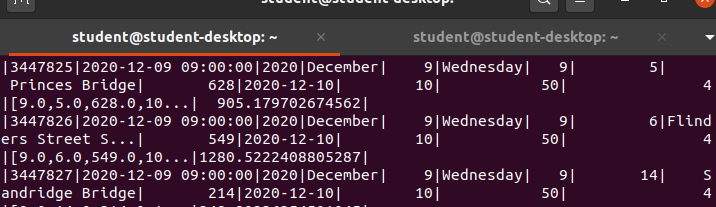

In [46]:
predictionsDF_query.stop()

In [66]:
predictionsDF_query_memory = predictionsDF.filter(col('Time').between(9,23))\
    .writeStream\
    .queryName('prediction_count')\
    .outputMode('append')\
    .format('memory')\
    .trigger(processingTime = '5 seconds')\
    .start()

In [73]:
# predictionsDF_query_memory.stop()

In [26]:
# Persist the prediction result in parquet format 
predictionsDF_sink = predictionsDF\
    .writeStream\
    .format("parquet")\
    .outputMode("append")\
    .option("path", "parquet/prediction_count")\
    .option("checkpointLocation", "path/to/checkpoint/dir")\
    .start()

In [27]:
predictionsDF_sink.stop()

## 8. Using the prediction result, and write code to process the data following the requirements below# 

a. For each sensor, get the number of hours that the predicted pedestrian count
would exceed 2000 on each day (for the hours between 9am-11:59pm). Show
them inside the notebook file.

In [67]:
predictionsDF_new = predictionsDF\
        .filter((col('Time').between(9,23)) & (col('prediction') > 2000))

In [68]:
from pyspark.sql.window import Window
from pyspark.sql.functions import count
w = Window.partitionBy("sensor_id").orderBy("Mdate")

In [69]:
predictionsDF_new_agg = predictionsDF_new\
        .select('sensor_id','Mdate','Time',count('Time').over(w).alias('count'))

In [70]:
predictionsDF_new_agg.printSchema()

root
 |-- sensor_id: integer (nullable = true)
 |-- Mdate: integer (nullable = true)
 |-- Time: integer (nullable = true)
 |-- count: long (nullable = false)



In [71]:
spark.sql('''
select sensor_id,
        to_date(Date_Time) AS date,
        Count(time) As num_of_hours
From    prediction_count
where   prediction > 2000
        and time between 9 and 23
group by sensor_id, date
order by sensor_id, date
''').show(truncate = False)

+---------+----------+------------+
|sensor_id|date      |num_of_hours|
+---------+----------+------------+
|1        |2020-12-14|5           |
|1        |2020-12-15|3           |
|2        |2020-12-14|6           |
|2        |2020-12-15|6           |
|4        |2020-12-14|6           |
|4        |2020-12-15|6           |
|5        |2020-12-15|1           |
|6        |2020-12-15|1           |
|22       |2020-12-14|1           |
|22       |2020-12-15|1           |
|24       |2020-12-14|1           |
|24       |2020-12-15|1           |
|41       |2020-12-14|7           |
|41       |2020-12-15|7           |
|59       |2020-12-14|1           |
|63       |2020-12-14|1           |
|63       |2020-12-15|1           |
|65       |2020-12-14|3           |
|65       |2020-12-15|2           |
|67       |2020-12-14|2           |
+---------+----------+------------+
only showing top 20 rows



b. If any sensor’s hourly count between 9am-11:59pm on the next day is
predicted to exceed 2000, combine the result with sensor longitude and
latitude information, and write the stream back to Kafka sink using a different
topic name
i. Hint - you might want to construct key and value columns before
writing the stream back to Kafka.

In [33]:
combin_df_value = predictionsDF.join(df_location, 'Sensor_ID').drop(df_location.sensor_name)\
        .filter((col('Time').between(9,23)) & (col('prediction') > 2000))\
        .select(struct(
        'Sensor_Name',
        'latitude',
        'longitude').alias('value'))

In [34]:
combin_df_value.printSchema()

root
 |-- value: struct (nullable = false)
 |    |-- Sensor_ID: integer (nullable = true)
 |    |-- Sensor_Name: string (nullable = true)
 |    |-- next_date: date (nullable = true)
 |    |-- prediction: double (nullable = false)
 |    |-- latitude: double (nullable = true)
 |    |-- longitude: double (nullable = true)



In [35]:
final_conbin_df = combin_df_value\
      .selectExpr("CAST(value AS STRING)") \
      .writeStream \
      .format("kafka") \
      .option("kafka.bootstrap.servers", "localhost:9092") \
      .option("topic", "prediction_of_count_new") \
      .option('checkpointLocation','kafka/to/prediction')\
      .start()